<a href="https://colab.research.google.com/github/SALMA55ASHRAF/ODC_training_advanced_BigData/blob/master/processing_data_sesor_odc_p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Java (required for Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Verify Java installation
!java -version



openjdk version "11.0.24" 2024-07-16
OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04)
OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)


In [2]:
!pip install -q pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os
from pyspark.sql import SparkSession

# Set environment variables (optional but recommended)
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.10/dist-packages/pyspark"

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SensorDataProcessing") \
    .getOrCreate()

# Verify Spark session
spark


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SensorDataProcessing") \
    .getOrCreate()


In [5]:
# Define the path to your CSV file
csv_file_path = "/content/colab_data.csv"  # Update this path if necessary

# Load CSV into Spark DataFrame
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("timestampFormat", "yyyy-MM-dd HH:mm:ss") \
    .load(csv_file_path)

# Show the first few rows
df.show(5)


+---+-------------------+---------+------------------+---------+------------------+---------+-----------------+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+---------+---------+---------+---------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------------------+---------+----------------+---------+---------+----------------+---------+-----------------+---------+---------+--------------+
|_c0|          timestamp|sensor_00|         sensor_01|sensor_02|         sensor_03|sensor_04|        sensor_05|         sensor_06|         sensor_07|         sensor_08|         sensor_09|sensor_10|         sensor_11|         sensor_12|         sensor_13|sensor_14|sensor_15|sensor_16|sensor_17|       

In [6]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sensor_00: double (nullable = true)
 |-- sensor_01: double (nullable = true)
 |-- sensor_02: double (nullable = true)
 |-- sensor_03: double (nullable = true)
 |-- sensor_04: double (nullable = true)
 |-- sensor_05: double (nullable = true)
 |-- sensor_06: double (nullable = true)
 |-- sensor_07: double (nullable = true)
 |-- sensor_08: double (nullable = true)
 |-- sensor_09: double (nullable = true)
 |-- sensor_10: double (nullable = true)
 |-- sensor_11: double (nullable = true)
 |-- sensor_12: double (nullable = true)
 |-- sensor_13: double (nullable = true)
 |-- sensor_14: double (nullable = true)
 |-- sensor_15: string (nullable = true)
 |-- sensor_16: double (nullable = true)
 |-- sensor_17: double (nullable = true)
 |-- sensor_18: double (nullable = true)
 |-- sensor_19: double (nullable = true)
 |-- sensor_20: double (nullable = true)
 |-- sensor_21: double (nullable = true)
 |-- sensor_2

In [7]:
# Select timestamp and a few sensor columns
df_selected = df.select("timestamp", "sensor_00", "sensor_01", "machine_status")
df_selected.show(5)


+-------------------+---------+------------------+--------------+
|          timestamp|sensor_00|         sensor_01|machine_status|
+-------------------+---------+------------------+--------------+
|2018-04-01 00:00:00| 2.465394|47.092009999999995|        NORMAL|
|2018-04-01 00:01:00| 2.465394|47.092009999999995|        NORMAL|
|2018-04-01 00:02:00| 2.444734|          47.35243|        NORMAL|
|2018-04-01 00:03:00| 2.460474|47.092009999999995|        NORMAL|
|2018-04-01 00:04:00| 2.445718|          47.13541|        NORMAL|
+-------------------+---------+------------------+--------------+
only showing top 5 rows



In [8]:
# Filter rows where machine_status is 'NORMAL'
df_normal = df.filter(df.machine_status == "NORMAL")
df_normal.show(5)


+---+-------------------+---------+------------------+---------+------------------+---------+-----------------+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+---------+---------+---------+---------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------------------+---------+----------------+---------+---------+----------------+---------+-----------------+---------+---------+--------------+
|_c0|          timestamp|sensor_00|         sensor_01|sensor_02|         sensor_03|sensor_04|        sensor_05|         sensor_06|         sensor_07|         sensor_08|         sensor_09|sensor_10|         sensor_11|         sensor_12|         sensor_13|sensor_14|sensor_15|sensor_16|sensor_17|       

In [9]:
# Calculate average value for each sensor
sensor_columns = [f"sensor_{i:02d}" for i in range(0, 52)]  # sensor_00 to sensor_51
from pyspark.sql.functions import avg

df.select([avg(c).alias(f"avg_{c}") for c in sensor_columns]).show(truncate=False)

# Group by machine_status and calculate average sensor values
df.groupBy("machine_status").agg(avg("sensor_00").alias("avg_sensor_00")).show()


+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+----------------+-----------------+-------------+------------------+------------------+
|avg_sensor_00     |avg_sensor_01    |avg_sensor_02    

In [10]:
# Extract hour from timestamp
from pyspark.sql.functions import hour

df_with_hour = df.withColumn("hour", hour("timestamp"))
df_with_hour.show(5)

# Aggregate data by hour
df_with_hour.groupBy("hour").agg(avg("sensor_00").alias("avg_sensor_00")).orderBy("hour").show()


+---+-------------------+---------+------------------+---------+------------------+---------+-----------------+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+---------+---------+---------+---------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------------------+---------+----------------+---------+---------+----------------+---------+-----------------+---------+---------+--------------+----+
|_c0|          timestamp|sensor_00|         sensor_01|sensor_02|         sensor_03|sensor_04|        sensor_05|         sensor_06|         sensor_07|         sensor_08|         sensor_09|sensor_10|         sensor_11|         sensor_12|         sensor_13|sensor_14|sensor_15|sensor_16|sensor_17|  

In [11]:
# Calculate average of sensor_00 and sensor_01 per minute
df_avg = df.groupBy("timestamp").agg(
    avg("sensor_00").alias("avg_sensor_00"),
    avg("sensor_01").alias("avg_sensor_01")
)

# Show the aggregated data
df_avg.show(5)


+-------------------+------------------+------------------+
|          timestamp|     avg_sensor_00|     avg_sensor_01|
+-------------------+------------------+------------------+
|2018-04-01 00:08:00|2.4634259999999997|47.092009999999995|
|2018-04-01 00:12:00|          2.460474|          48.26389|
|2018-04-01 00:09:00|          2.445718|          47.17882|
|2018-04-01 00:17:00|2.4634259999999997|           48.4809|
|2018-04-01 00:11:00|          2.444734|          47.91666|
+-------------------+------------------+------------------+
only showing top 5 rows



In [12]:
# Limit data for visualization purposes
df_avg_pd = df_avg.limit(100).toPandas()

# Ensure data is sorted by timestamp
df_avg_pd = df_avg_pd.sort_values("timestamp")


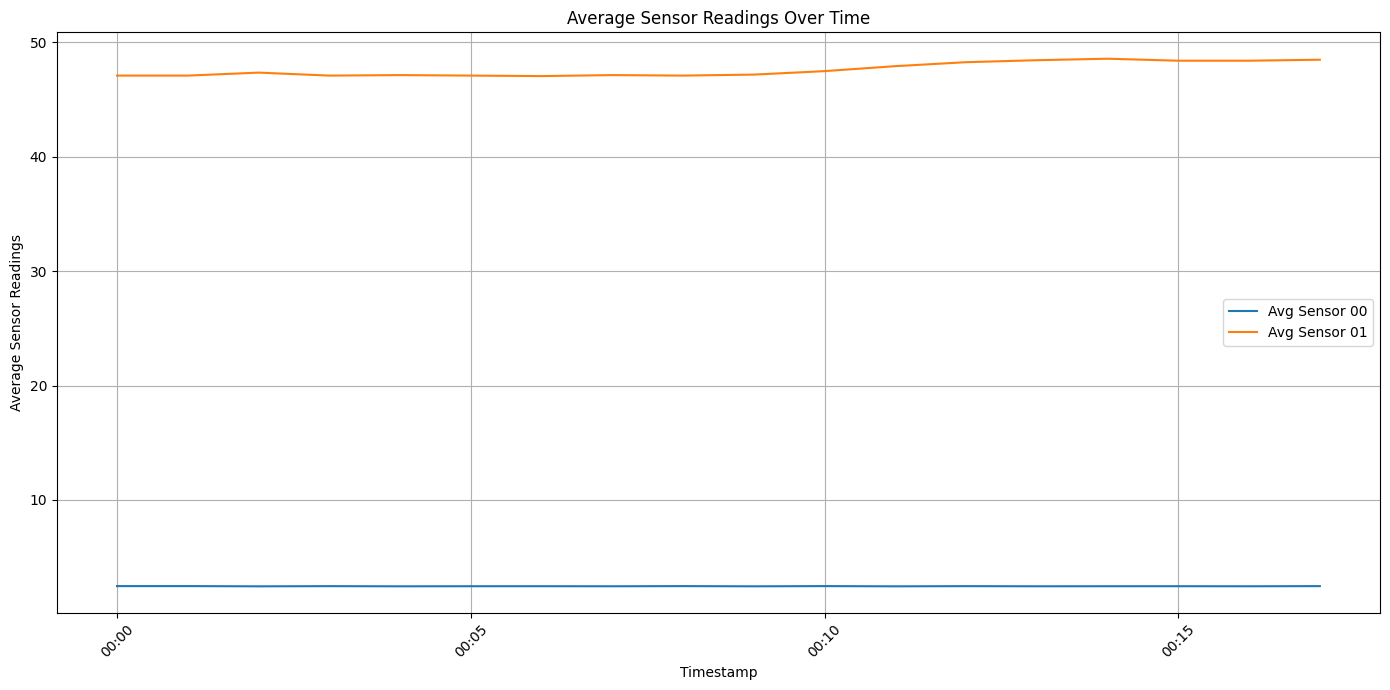

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the plot size
plt.figure(figsize=(14, 7))

# Plot average sensor_00
plt.plot(df_avg_pd['timestamp'], df_avg_pd['avg_sensor_00'], label='Avg Sensor 00')

# Plot average sensor_01
plt.plot(df_avg_pd['timestamp'], df_avg_pd['avg_sensor_01'], label='Avg Sensor 01')

# Formatting the date on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Average Sensor Readings')
plt.title('Average Sensor Readings Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [26]:
from pyspark.sql.functions import col, sum

# Calculate the number of NULLs in each column
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Display the count of NULLs per column
missing_values.show(truncate=False)


+---+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+
|_c0|timestamp|sensor_00|sensor_01|sensor_02|sensor_03|sensor_04|sensor_05|sensor_06|sensor_07|sensor_08|sensor_09|sensor_10|sensor_11|sensor_12|sensor_13|sensor_14|sensor_15|sensor_16|sensor_17|sensor_18|sensor_19|sensor_20|sensor_21|sensor_22|sensor_23|sensor_24|sensor_25|sensor_26|sensor_27|sensor_28|sensor_29|sensor_30|sensor_31|sensor_32|sensor_33|sensor_34|sensor_35|sensor_36|sensor_37|sensor_38|sensor_39|sensor_40|sensor_41|sensor_42|sens

In [28]:
df_filtered = df.filter(df.sensor_15.isNotNull())



In [29]:
df_filled = df.fillna({'sensor_15': 0})


In [30]:
df_dropped = df.drop("sensor_15")


In [31]:
df_dropped.show()

+---+-------------------+------------------+------------------+------------------+------------------+---------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+------------------+---------+---------+---------+---------+-----------------+---------+---------+---------+------------------+-----------------+---------+-----------------+---------+---------+---------+---------+---------+------------------+-----------------+---------+---------+---------+------------------+------------------+---------+----------------+------------------+------------------+----------------+---------+-----------------+---------+---------+--------------+
|_c0|          timestamp|         sensor_00|         sensor_01|         sensor_02|         sensor_03|sensor_04|        sensor_05|         sensor_06|         sensor_07|         sensor_08|         sen

In [32]:
# Drop the '_c0' column if it's just an index
df_final = df_dropped.drop("_c0")


In [33]:
# Display the schema to verify data types and column names
df_final.printSchema()

# Show the first few rows to verify the data
df_final.show(5, truncate=False)


root
 |-- timestamp: timestamp (nullable = true)
 |-- sensor_00: double (nullable = true)
 |-- sensor_01: double (nullable = true)
 |-- sensor_02: double (nullable = true)
 |-- sensor_03: double (nullable = true)
 |-- sensor_04: double (nullable = true)
 |-- sensor_05: double (nullable = true)
 |-- sensor_06: double (nullable = true)
 |-- sensor_07: double (nullable = true)
 |-- sensor_08: double (nullable = true)
 |-- sensor_09: double (nullable = true)
 |-- sensor_10: double (nullable = true)
 |-- sensor_11: double (nullable = true)
 |-- sensor_12: double (nullable = true)
 |-- sensor_13: double (nullable = true)
 |-- sensor_14: double (nullable = true)
 |-- sensor_16: double (nullable = true)
 |-- sensor_17: double (nullable = true)
 |-- sensor_18: double (nullable = true)
 |-- sensor_19: double (nullable = true)
 |-- sensor_20: double (nullable = true)
 |-- sensor_21: double (nullable = true)
 |-- sensor_22: double (nullable = true)
 |-- sensor_23: double (nullable = true)
 |-- sen

In [34]:
from pyspark.sql.functions import to_timestamp, hour, dayofmonth, month, year

# Convert timestamp string to TimestampType
df_final = df_final.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))

# Extract features from timestamp
df_final = df_final.withColumn("hour", hour(col("timestamp"))) \
                   .withColumn("day", dayofmonth(col("timestamp"))) \
                   .withColumn("month", month(col("timestamp"))) \
                   .withColumn("year", year(col("timestamp")))


In [35]:
# Drop the timestamp column
df_final = df_final.drop("timestamp")


In [36]:
# List of sensor columns (excluding 'sensor_15' and '_c0')
sensor_columns = [c for c in df_final.columns if c.startswith("sensor_")]

# Define the label column
label_column = "machine_status"

# Select features and label
data = df_final.select(sensor_columns + [label_column])


In [37]:
from pyspark.ml.feature import StringIndexer

# Initialize StringIndexer
label_indexer = StringIndexer(inputCol=label_column, outputCol="label")

# Fit and transform the data
data_indexed = label_indexer.fit(data).transform(data)

# Verify the transformation
data_indexed.select(label_column, "label").show(5)


+--------------+-----+
|machine_status|label|
+--------------+-----+
|        NORMAL|  0.0|
|        NORMAL|  0.0|
|        NORMAL|  0.0|
|        NORMAL|  0.0|
|        NORMAL|  0.0|
+--------------+-----+
only showing top 5 rows



In [38]:
from pyspark.ml.feature import VectorAssembler

# Initialize VectorAssembler
assembler = VectorAssembler(inputCols=sensor_columns, outputCol="features")

# Transform the data
data_prepared = assembler.transform(data_indexed)

# Select only the necessary columns for modeling
model_data = data_prepared.select("features", "label")


In [39]:
# If timestamp features were added
assembler = VectorAssembler(inputCols=sensor_columns + ["hour", "day", "month", "year"], outputCol="features")


In [40]:
# Split the data
train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=42)

# Display counts
print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")


Training Data Count: 14
Testing Data Count: 4


In [41]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, seed=42)

# Create the Pipeline
pipeline = Pipeline(stages=[rf])


In [42]:
# Train the model
model = pipeline.fit(train_data)


In [43]:
# Make predictions on the test data
predictions = model.transform(test_data)

# Show sample predictions
predictions.select("features", "label", "prediction").show(5)


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[2.445718,47.1354...|  0.0|       0.0|
|[2.449653,48.3941...|  0.0|       0.0|
|[2.453588,48.5677...|  0.0|       0.0|
|[2.46342599999999...|  0.0|       0.0|
+--------------------+-----+----------+



In [44]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, seed=42)

# Create the Pipeline
pipeline = Pipeline(stages=[rf])


In [45]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Initialize StringIndexer
label_indexer = StringIndexer(inputCol="machine_status", outputCol="label")

# Initialize VectorAssembler
assembler = VectorAssembler(inputCols=sensor_columns, outputCol="features")

# Initialize RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, seed=42)

# Create the Pipeline
pipeline = Pipeline(stages=[label_indexer, assembler, rf])


In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test data
predictions = model.transform(test_data)

# Show sample predictions
predictions.select("features", "label", "prediction").show(5)


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[2.445718,47.1354...|  0.0|       0.0|
|[2.449653,48.3941...|  0.0|       0.0|
|[2.453588,48.5677...|  0.0|       0.0|
|[2.46342599999999...|  0.0|       0.0|
+--------------------+-----+----------+



In [48]:
# Initialize the evaluator for Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

# Calculate Accuracy
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.2f}")

# Initialize the evaluator for Precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)
print(f"Test Precision = {precision:.2f}")

# Initialize the evaluator for Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)
print(f"Test Recall = {recall:.2f}")

# Initialize the evaluator for F1 Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)
f1 = f1_evaluator.evaluate(predictions)
print(f"Test F1 Score = {f1:.2f}")


Test Accuracy = 1.00
Test Precision = 1.00
Test Recall = 1.00
Test F1 Score = 1.00


In [49]:
from pyspark.sql import Row
from pyspark.ml.feature import IndexToString

# Example new sensor data (replace with actual values)
new_data = [
    Row(sensor_00=2.450000, sensor_01=47.00000, sensor_02=53.2000, sensor_03=46.3000, sensor_04=634.0000,
        sensor_05=76.0000, sensor_06=13.4000, sensor_07=16.1000, sensor_08=15.5000, sensor_09=15.0000,
        sensor_10=37.2000, sensor_11=47.5000, sensor_12=31.1000, sensor_13=1.6800, sensor_14=419.5000,
        sensor_16=461.8000, sensor_17=466.3000, sensor_18=2.5600, sensor_19=665.4000, sensor_20=399.0000,
        sensor_21=880.0000, sensor_22=498.8000, sensor_23=975.9000, sensor_24=627.6000, sensor_25=741.7000,
        sensor_26=848.0000, sensor_27=429.0000, sensor_28=785.0000, sensor_29=684.9000, sensor_30=594.4000,
        sensor_31=682.8000, sensor_32=680.4000, sensor_33=433.7000, sensor_34=171.9000, sensor_35=341.9000,
        sensor_36=195.0000, sensor_37=90.3000, sensor_38=40.3000, sensor_39=31.5000, sensor_40=70.5000,
        sensor_41=30.9000, sensor_42=31.7708, sensor_43=41.9000, sensor_44=39.6000, sensor_45=65.6000,
        sensor_46=50.9000, sensor_47=38.2000, sensor_48=158.0000, sensor_49=67.7000, sensor_50=243.0000,
        sensor_51=201.3000)
]

# Create a DataFrame for new data
new_df = spark.createDataFrame(new_data)

# Assemble features
new_df_assembled = assembler.transform(new_df)

# Make predictions
new_predictions = model.transform(new_df_assembled)

# Initialize IndexToString to convert numerical labels back to original labels
label_converter = IndexToString(inputCol="prediction", outputCol="predicted_machine_status",
                                labels=label_indexer.fit(data).labels)

# Convert predictions back to original labels
final_predictions = label_converter.transform(new_predictions)

# Show the final predictions
final_predictions.select("features", "prediction", "predicted_machine_status").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------------+
|features                                                                                                                                                                                                                                                                                    |prediction|predicted_machine_status|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------------+
|[2.45,47.0,53.2,46.3,634.0,76.

In [50]:
# Save the model
model.save("/content/random_forest_model")

# To load the model later
from pyspark.ml.pipeline import PipelineModel
loaded_model = PipelineModel.load("/content/random_forest_model")
